In [64]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, spectrogram, convolve, find_peaks, savgol_filter
from scipy.io import wavfile
import sounddevice as sd
import subprocess

from utilities import *

In [14]:
# constellation_map = {
#     '00' : complex(1/np.sqrt(2), 1/np.sqrt(2)),
#     '01' : complex(-1/np.sqrt(2), 1/np.sqrt(2)),
#     '11' : complex(-1/np.sqrt(2), -1/np.sqrt(2)),
#     '10' : complex(1/np.sqrt(2), -1/np.sqrt(2)),
# }
constellation_map = {
    0: 1,
    1: -1,
}

QAM_symbols = np.array([*constellation_map.values()])
QAM_bits = np.array([*constellation_map.keys()])

In [15]:
N = 8192
L = 1024

source = np.random.choice(list(constellation_map.values()), (N-2)//2)
source
subcarrier_data = np.concatenate(([0], source, [0], np.conjugate(np.flip(source))))
x = np.fft.ifft(subcarrier_data).real
OFDM_symbol = np.concatenate((x[-L:], x))
OFDM_symbol /= np.max(np.abs(OFDM_symbol))

In [16]:
fs = 44100

t_chirp = np.linspace(0,1,fs)
chirp_standard = chirp(t_chirp, 1e3, 1, 10e3, method='linear')

pause = np.zeros(fs)

whitenoise = np.random.randn(fs)
whitenoise /= np.max(np.abs(whitenoise))

standard = np.concatenate([pause, chirp_standard, pause, whitenoise, pause])

OFDM_frame = np.tile(OFDM_symbol, 10)
signal = np.concatenate([standard, OFDM_frame])

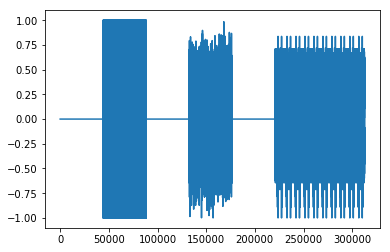

In [17]:
plt.plot(signal)

In [18]:
write('OFDM/test_frame.wav', fs, signal)

In [19]:
subprocess.Popen(["afplay", "OFDM/test_frame.wav"])
received = sd.rec(len(signal), samplerate = fs, channels = 1, blocking = True).flatten()
write('OFDM/received_frame.wav', fs, received)

In [20]:
def synchronise(received, chirp_standard):
    conv = convolve(received, np.flip(chirp_standard), mode='same')
    return np.argmax(np.abs(conv))

In [21]:
%matplotlib qt
plt.plot(received)
start = synchronise(received, chirp_standard)
for i in range(-2,13):
    plt.axvline(x=start+i*fs//2, c='r')
plt.show()

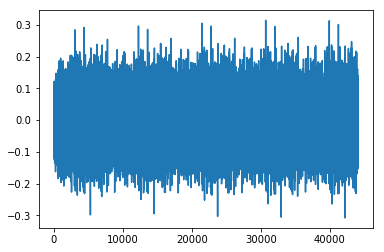

In [22]:
%matplotlib inline
received_frame = received[start+int(3.5*fs):start+int(4.5*fs)]
plt.plot(received_frame)

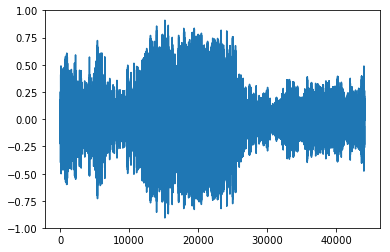

In [23]:
received_chirp = received[start-int(0.5*fs):start+int(0.5*fs)]
plt.plot(received_chirp)

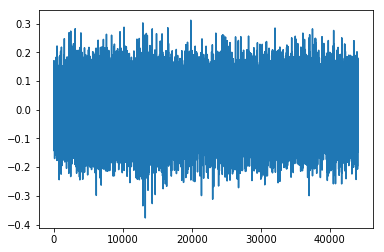

In [36]:
received_whitenoise = received[start+int(1.5*fs):start+int(2.5*fs)]
plt.plot(received_whitenoise)

## FrFT Channel estimation

In [24]:
res = optimise_a(chirp_standard)
res

     fun: -72.79829573355825
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 0.8718468064328603

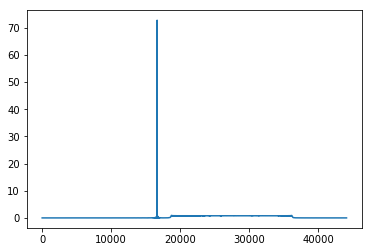

In [26]:
plt.plot(np.abs(frft(chirp_standard, res.x)))

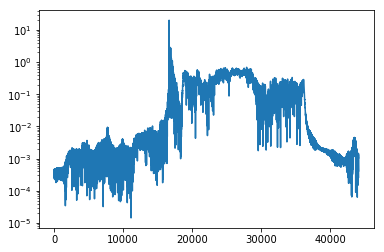

In [30]:
Y_alpha_opt = frft(received_chirp, res.x)
plt.plot(np.abs(Y_alpha_opt))
plt.yscale('log')

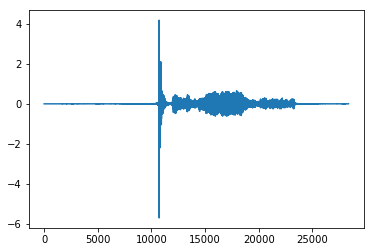

In [49]:
time_axes = np.arange(0,len(Y_alpha_opt), 1/np.cos(res.x))
frft_axes = np.arange(0,len(Y_alpha_opt))
Y_alpha_opt_t = np.interp(time_axes, frft_axes,Y_alpha_opt)
plt.plot(Y_alpha_opt_t)

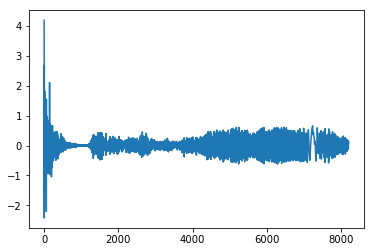

In [53]:
peak= np.argmax(Y_alpha_opt_t)
h = Y_alpha_opt_t[peak:peak+N]
plt.plot(h)

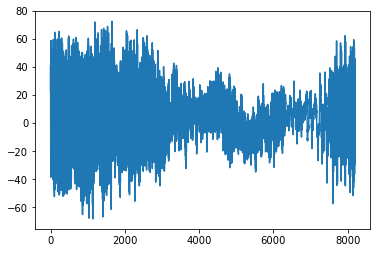

In [54]:
H = np.fft.fft(h)
plt.plot(H)

/Users/matthewbarker/opt/anaconda3/envs/scienv/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


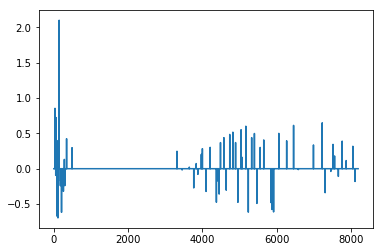

In [62]:
peaks, _ = find_peaks(np.abs(h), prominence=0.2, width=2)
h_smooth = np.zeros(len(h))
h_smooth[peaks] = h[peaks]
plt.plot(h_smooth)

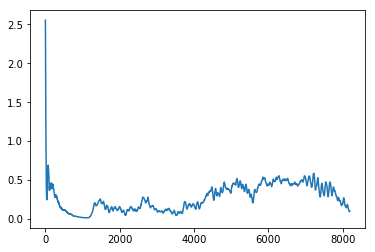

In [66]:
h_savgol = savgol_filter(abs(h), 101, 3) 
plt.plot(h_savgol)

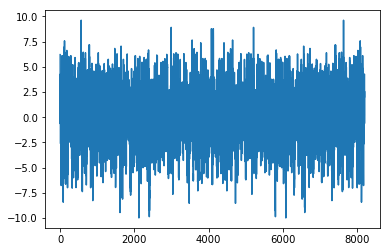

In [69]:
H_smooth = np.fft.fft(h_smooth)
plt.plot(H_smooth)

## White noise channel estimation

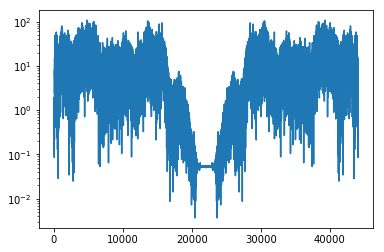

In [74]:
plt.plot(np.abs(np.fft.fft(received_whitenoise)))
# plt.xscale('log')
plt.yscale('log')

## Decoding

In [55]:
received_frame

array([-0.01765167, -0.01572872,  0.00995346, ..., -0.01195882,
       -0.01704313,  0.12800537], dtype=float32)

In [58]:
r = received_frame[L:(L+N)]

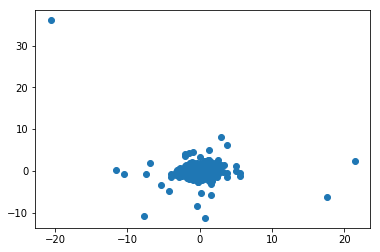

In [73]:
%matplotlib inline
R = np.fft.fft(r)
Xhat = R/H # deconvolution

plt.scatter(Xhat.real, Xhat.imag)

## Convolution channel estimation

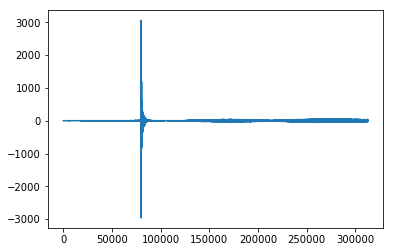

In [92]:
%matplotlib inline
conv = convolve(received, np.flip(chirp_standard), mode='same')
plt.plot(conv)

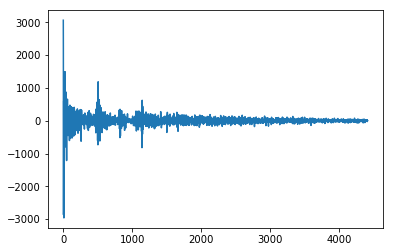

In [93]:
%matplotlib inline
impulse = conv[start:start+int(0.1*fs)]
plt.plot(conv[start:start+int(0.1*fs)])

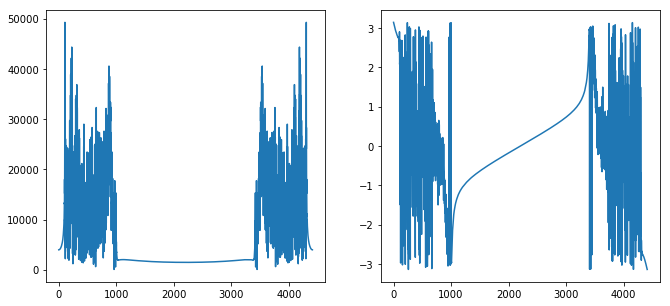

In [95]:
H = np.fft.fft(impulse)
plt.subplots(figsize=(11,5))
plt.subplot(1,2,1)
plt.plot(np.abs(H))
plt.subplot(1,2,2)
plt.plot(np.angle(H))

In [96]:
from scipy.signal import find_peaks

/Users/matthewbarker/opt/anaconda3/envs/scienv/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


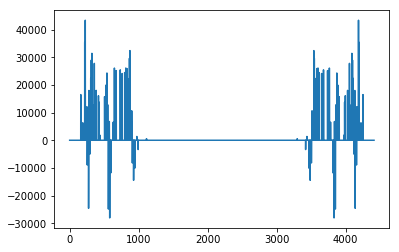

In [97]:
peaks, _ = find_peaks(np.abs(H), prominence=0.5, width=3)
H_smooth = np.zeros(len(H))
H_smooth[peaks] = H[peaks]
plt.plot(H_smooth)